# Uncertainty quantification for cross sections
This tutorial will demonstrate how to use jitr to perform uncertainty quantification of a simple reaction observable: differential elastic scattering cross sections. We will use the uncertainty quantified optical potential KDUQ introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602). Jitr includes an implementation of the kduq potential, as well as a set of samples of the posterior provided in the supplemental material of that paper.

In [1]:
from pathlib import Path

import corner

# import stuff for nice plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from numba import njit
from scipy import stats
from tqdm import tqdm

import jitr

We will use [exfor-tools](https://github.com/beykyle/exfor_tools) using an [x4i3](https://github.com/afedynitch/x4i3/) backend for grabbing data from [EXFOR](https://www-nds.iaea.org/exfor/) (requires 1GB of disk space to download).

In [2]:
#!pip install x4i3

In [3]:
import exfor_tools

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


### Let's find some data to compare to
Let's grab some data from [EXFOR](https://www-nds.iaea.org/exfor/). We will look at $d\sigma_{el}/d\Omega$ for $(n,n)$ and $(p,p)$.

In [4]:
# target to consider
Pb208 = (208, 82)

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

In [5]:
all_entries = exfor_tools.get_exfor_differential_data(
    target=Pb208,
    projectile=(1, 0),
    quantity="dXS/dA",
    product="EL",
    energy_range=[7, 20],  # MeV
)
all_measurements = exfor_tools.sort_measurements_by_energy(all_entries)
print(
    f"Found measurements at {len(list(all_entries))} different energies for (n,n) on 208-Pb"
)

Found measurements at 9 different energies for (n,n) on 208-Pb


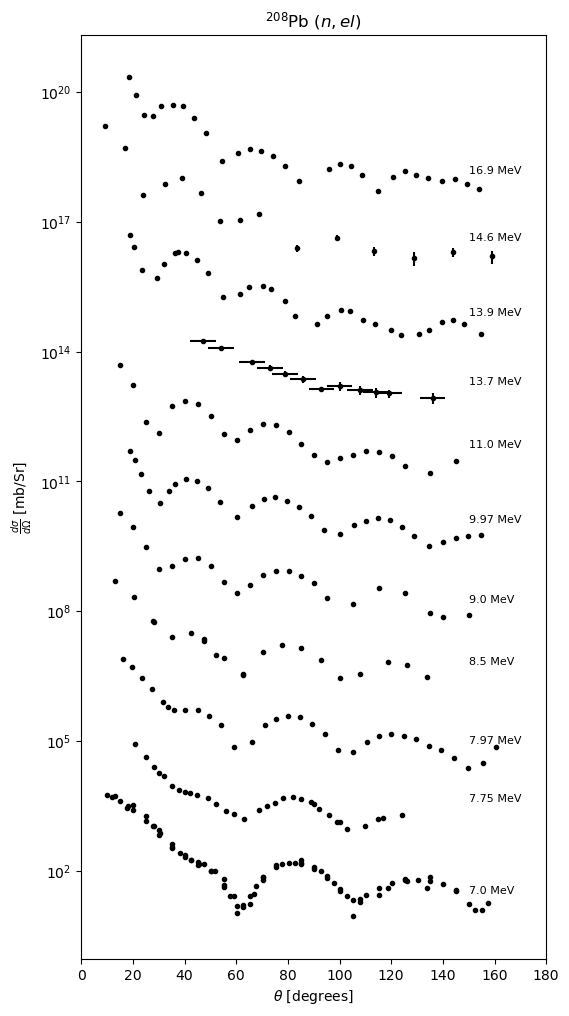

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
exfor_keys = list(all_entries.keys())
all_entries[exfor_keys[0]].plot_experiment(
    ax,
    all_measurements,
    offsets=50,
    label_offset_factor=2,
    label_hloc_deg=150,
    label_energy_err=False,
    label_offset=False,
)

### Let's set up our solver to calculate $^{208}$Pb $(p,p)$ differential cross sections

We will use the the KDUQ potential from [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602) potential. The supplemental material in that link contains a set of samples from the posterior of the KDUQ parameter distribution. Let's load them up:

In [7]:
import rose

In [8]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    Path(f"./../../src/data/KDUQFederal/{i}/parameters.json")
    for i in range(0, num_samples_kduq)
]

# load each one
kduq_omps = [
    rose.koning_delaroche.KDGlobal(rose.Projectile.neutron, Path(param_file))
    for param_file in param_files
]

We will create an instance of a `rose.InteractionSpace` and a `rose.ScatteringAmplitudeEmulator` for each of these potentials, and we will use the high-fidelity solver to calculate the cross sections predicted by each model.

We will use a high-fidelity solver from the [jitr package](https://github.com/beykyle/jitr) which uses the R-Matrix method on a Lagrange-Legendre mesh.

In [9]:
core_solver = jitr.rmatrix.Solver(40)

In [10]:
num_samples_pred_post = 50
energies = []
kduq_pred_post = []
kduq_solvers = []

# for each experiment, and for each parameter sample,
# use the rose high-fidelity solver to calculate the
# KDUQ prediction

for measurement in all_measurements:
    Ecm = measurement.Ecm
    dEcm = measurement.dEcm
    energies.append(Ecm)
    print(f"Running UQ  at {Ecm} MeV")

    # get kinematics and parameters for this experiment
    mu, Elab, k, eta = rose.utility.kinematics(Pb208, (1, 0), E_com=Ecm)

    kduq = rose.InteractionSpace(
        coordinate_space_potential=rose.koning_delaroche.KD_simple,
        n_theta=rose.koning_delaroche.NUM_PARAMS,
        is_complex=True,
        spin_orbit_term=rose.koning_delaroche.KD_simple_so,
        energy=Ecm,
        mu=mu,
        k=k,
        l_max=15,
    )
    rmatrix_solver = rose.LagrangeRmatrix(
        kduq.interactions[0][0],
        np.pi * 10,
        core_solver,
    )
    kduq_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            base_solver=rmatrix_solver,
            interaction_space=kduq,
            angles=angles,
        )
    )

    # get a differential xs for each parameter sample
    kduq_xs = np.zeros((len(angles), num_samples_pred_post))
    samples = np.random.choice(num_samples_kduq, size=num_samples_pred_post)

    for i, sample in enumerate(tqdm(samples)):
        omp = kduq_omps[sample]
        R_C, params = omp.get_params(*Pb208, mu, Elab, k)
        kduq_xs[:, i] = kduq_solvers[-1].exact_xs(params).dsdo

    # get a credible interval describing the KDUQ predictive posterior
    # for this experiment
    kduq_pred_post.append(
        (
            np.percentile(kduq_xs, 5, axis=1),
            np.percentile(kduq_xs, 95, axis=1),
        )
    )

Running UQ  at 7.0 MeV


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m- Resolution failure for literal arguments:
[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:

 >>> setitem(array(complex128, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))

There are 16 candidate implementations:
[1m      - Of which 16 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(array(complex128, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of setitem at /home/beyerk/Projects/jitr/src/jitr/quadrature/quadrature.py (217)[0m
[1m
File "../../src/jitr/quadrature/quadrature.py", line 217:[0m
[1m    def kinetic_matrix(self, a: float64, l: int32):
        <source elided>
            for m in range(n, self.nbasis + 1):
[1m                F[n - 1, m - 1] = self.kinetic_operator_element(n, m, a, l)
[0m                [1m^[0m[0m
[0m
[0m[1m- Resolution failure for non-literal arguments:
[1mNone[0m
[0m[0m
[0m[1mDuring: resolving callee type: BoundFunction((<class 'numba.core.types.misc.ClassInstanceType'>, 'kinetic_matrix') for instance.jitclass.LagrangeLegendreQuadrature#7b85c5461e10<nbasis:int32,abscissa:array(float64, 1d, A),weights:array(float64, 1d, A),overlap:array(float64, 2d, A)>)[0m
[0m[1mDuring: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m


Now that we have our model predictions, lets plot them compared to the experimental data. We will offset each energy for visibility.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
exfor_keys = list(all_entries.keys())
all_entries[exfor_keys[0]].plot_experiment(
    ax,
    all_measurements,
    offsets=50,
    label_offset_factor=2,
    label_hloc_deg=150,
    label_energy_err=False,
    label_offset=True,
)
offsets = 50 ** np.arange(len(all_measurements))
for i, Ecm in enumerate(energies):
    # plot model
    ax.fill_between(
        angles * 180 / np.pi,
        offsets[i] * kduq_pred_post[i][0],
        offsets[i] * kduq_pred_post[i][1],
        color="#ff4500",
        alpha=0.5,
    )